## Libraries

In [17]:
import copy

import casadi as ca
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from scipy.linalg import inv

## Parameters

In [18]:
# Original parameters given to us
params_og = {
      't_lag': 7,
      'k_C': 0.3828,
      'k_N': 1.0027e-4, 
      'Y': {'X_C': 0.484,
      'X_N': 21.575, 
      'X_CO2': 0.3687}, 
      'Xmax': 1.4462,
      'mu_max': 0.19,
      'k_d': 0.001, 
      'pH': {'pka1': 6.86, # pKa of KH2PO4
            'pka2': 3.13,  # pka of C6H8O7
            'pka3': 4.76,  # pka of (C6H7O7)-
            'pka4': 6.40,  # pka of (C6H6O7)2-
            'pka5': 9.25,  # pka of NH3
            'pka6': 14.15, # pka of C3H8O3
            'pka7': 6.35,  # pka of CO2
            'pka8': 10.33, # pka of (HCO3)-
            'pka9': 14,    # pka of H2O
            'conc': {'KH2PO4': 2.18,
                  'C6H8O7': 2},
            'LL': 3.4687,
            'UL': 7.4,
            'alk': 7.2},
      'I_val': 4.0413,
      'pH_M': [0, 14]} 

# Parameters for saturated oxygen
params_o2 = copy.deepcopy(params_og)
params_o2['Y']['X_O2'] = 1.352
params_o2['O2_sat']    = 0.007267
params_o2['k_La']      = 86.26
params_o2['k_O']       = 0.0045

## Experimental data

### Fitting Data

In [19]:
exp_data_norm_fit = pd.read_excel('Experimental_data.xlsx', sheet_name='Fitting Data')

t_exp_norm_fit = exp_data_norm_fit.iloc[:, 0]

X_exp_norm_fit         = exp_data_norm_fit.iloc[:, 1]
X_weight_norm_fit      = exp_data_norm_fit.iloc[:, 2]
X_SE_norm_fit          = exp_data_norm_fit.iloc[:, 3]

C_exp_norm_fit         = exp_data_norm_fit.iloc[:, 4]
C_weight_norm_fit      = exp_data_norm_fit.iloc[:, 5]
C_SE_norm_fit          = exp_data_norm_fit.iloc[:, 6]

N_exp_norm_fit         = exp_data_norm_fit.iloc[:, 7]
N_weight_norm_fit      = exp_data_norm_fit.iloc[:, 8]
N_SE_norm_fit          = exp_data_norm_fit.iloc[:, 9]

pH_exp_norm_fit        = exp_data_norm_fit.iloc[:, 10]
pH_weight_norm_fit     = exp_data_norm_fit.iloc[:, 11]
pH_SE_norm_fit         = exp_data_norm_fit.iloc[:, 12]

x_exp = np.vstack([
    exp_data_norm_fit.iloc[:, 1],   # X
    exp_data_norm_fit.iloc[:, 4],   # C
    exp_data_norm_fit.iloc[:, 7],   # N
    exp_data_norm_fit.iloc[:, 10]   # pH
]).T

weights_exp = np.vstack([
    exp_data_norm_fit.iloc[:, 2],   # X_weight
    exp_data_norm_fit.iloc[:, 5],   # C_weight
    exp_data_norm_fit.iloc[:, 8],   # N_weight
    exp_data_norm_fit.iloc[:, 11]   # pH_weight
]).T

t_exp = np.array(t_exp_norm_fit)

## DAE system

In [20]:
def DAE_system(t, vars, z_algebraic, params):

    # Unpack variables
    X, C, N, CO2, O = vars[0], vars[1], vars[2], vars[3], vars[4]
    w = z_algebraic[0] # pH

    # Explicit algebraic equations
    # pH inhibition factor
    Iph = ca.exp((params['I_val'] * ((w - params['pH']['UL']) / (params['pH']['UL'] - params['pH']['LL']))) ** 2)

    # Specific growth rate
    mu = (params['mu_max'] 
          * (1 - ca.exp(-t / params['t_lag'])) 
          * (C / (C + params['k_C'])) 
          * (N / (N + params['k_N'])) 
          * (O / (O + params['k_O']))
          * (1 - (X / (params['Xmax']))) 
          * Iph)
    
    ka7 = 10 ** (-params['pH']['pka7'])

    # Differential equations
    dXdt   = (mu- params['k_d']) * X                                                     # Biomass
    dCdt   = - (mu / params['Y']['X_C']) * X                                             # Glycerol
    dNdt   = - (mu / params['Y']['X_N']) * X                                             # Ammonia
    dCO2dt = ((mu / params['Y']['X_CO2']) * X) - ka7 * (CO2 / (((10 ** -w) / ka7) + 1))  # CO2
    dOdt   = params['k_La'] * (params['O2_sat'] - O) - (mu / params['Y']['X_O2']) * X    # O2

    return ca.vertcat(dXdt, dCdt, dNdt, dCO2dt, dOdt)

In [21]:
# Symbolic variables
t = ca.MX.sym('t')
x = ca.MX.sym('x', 5)  # [X, C, N, CO2, O2]
z = ca.MX.sym('z')     # [pH]

# Systems's differential equations
dxdt = DAE_system(t, x, z, params_o2)

# Algebraic equation
# Parameters
ka1 = 10 ** (-params_o2['pH']['pka1'])  # KH2PO4
ka2 = 10 ** (-params_o2['pH']['pka2'])  # C6H8O7
ka3 = 10 ** (-params_o2['pH']['pka3'])  # (C6H7O7)-
ka4 = 10 ** (-params_o2['pH']['pka4'])  # (C6H6O7)2-
ka7 = 10 ** (-params_o2['pH']['pka7'])  # CO2
ka9 = 10 ** (-params_o2['pH']['pka9'])  # H2O

H = 10 ** (-z) 

# Concentration of charges according to H+ ions
KHPO4  = params_o2['pH']['conc']['KH2PO4'] / ((H / ka1) + 1)
C6H5O7 = params_o2['pH']['conc']['C6H8O7'] / ((H ** 3 / (ka2 * ka3 * ka4)) + (H ** 2 / (ka3 * ka4)) + (H / ka4) + 1)
C6H6O7 = (H / ka4) * C6H5O7
C6H7O7 = (H / ka3) * C6H6O7
HCO3   = x[3] / ((H / ka7) + 1)
OH     = ka9 / H

f_z = OH + HCO3 + KHPO4 + (3 * C6H5O7) + (2 * C6H6O7) + C6H7O7 - params_o2['pH']['alk'] - H

# CasADi function
f_O2 = ca.Function('f', [t, x, z], [dxdt])

In [22]:
# Initial conditions
X0   = 0.223
c0   = 5.922
n0   = 1.027
co20 = 0.439 / 1000
o20  = params_o2['O2_sat']
x0   = np.array([X0, c0, n0, co20, o20])

z0 = np.array([0.0])  # Initial guess for pH

# Final time and number of integration steps
tf = 40
n_steps = 500

# Simulation time vector
t_values = np.linspace(0, tf, n_steps + 1)

# ODE system
dae = {'t': t, 'x': x, 'z': z, 'ode': f_O2(t,x,z), 'alg': f_z}
integrator_O2 = ca.integrator('integrator', 'idas', dae, {'grid': t_values, 'output_t0': True})

# Solve
sol_casadi_O2 = integrator_O2(x0=x0, z0=z0)

In [23]:
# Extract results
t_casadi_O2 = np.linspace(0, 40, 501)
x_final_O2  = sol_casadi_O2['xf'].full().T
z_final_O2  = sol_casadi_O2['zf'].full().T

X_casadi_O2   = x_final_O2[:, 0]
C_casadi_O2   = x_final_O2[:, 1]
N_casadi_O2   = x_final_O2[:, 2]
CO2_casadi_O2 = x_final_O2[:, 3]
O2_casadi_O2  = x_final_O2[:, 4]
pH_casadi_O2  = z_final_O2[:, 0]

# Compute specific growth rate over time
mu_values_casadi_O2 = np.zeros_like(C_casadi_O2)
for i in range(len(C_casadi_O2)):
    mu_values_casadi_O2[i] = (params_o2['mu_max'] 
                              * (1 - np.exp(-t_casadi_O2[i] / params_o2['t_lag'])) 
                              * (C_casadi_O2[i] / (C_casadi_O2[i] + params_o2['k_C'])) 
                              * (N_casadi_O2[i] / (N_casadi_O2[i] + params_o2['k_N'])) 
                              * (O2_casadi_O2[i] / (O2_casadi_O2[i] + params_o2['k_O'])) 
                              * np.exp((params_o2['I_val'] * ((pH_casadi_O2[i] - params_o2['pH']['UL']) / (params_o2['pH']['UL'] - params_o2['pH']['LL']))) ** 2) 
                              *(1 - X_casadi_O2[i] / params_o2['Xmax']))

## Sensitivity Analysis

### Aux functions

In [24]:
def get_nested(dic, key_str):
    keys = key_str.split('.')
    val = dic
    for k in keys:
        val = val[k]
    return val

def set_nested(dic, key_str, value):
    keys = key_str.split('.')
    d = dic
    for k in keys[:-1]:
        d = d[k]
    d[keys[-1]] = value

def get_all_numeric_keys(d, prefix=''):
    keys = []
    for k, v in d.items():
        full_key = f"{prefix}.{k}" if prefix else k
        if isinstance(v, dict):
            keys.extend(get_all_numeric_keys(v, full_key))
        elif isinstance(v, (int, float)):
            keys.append(full_key)
    return keys

def simulate(params_mod):
    dxdt_mod = DAE_system(t, x, z, params_mod)
    dae_mod = {'t': t, 'x': x, 'z': z, 'ode': dxdt_mod, 'alg': f_z}
    integrator = ca.integrator('integrator', 'idas', dae_mod, {'grid': t_values, 'output_t0': True})
    sol = integrator(x0=x0, z0=z0)
    xf = sol['xf'].full().T
    zf = sol['zf'].full().T
    return xf[:, 0], xf[:, 1], xf[:, 2], zf[:, 0]  # X, C, N, pH

def set_params(params_base, p_vector, keys):
    params = copy.deepcopy(params_base)
    for val, key in zip(p_vector, keys):
        keys_split = key.split('.')
        d = params
        for k in keys_split[:-1]:
            d = d[k]
        d[keys_split[-1]] = val
    return params

def model_fun(p_dict):
    dxdt_mod = DAE_system(t, x, z, p_dict)
    dae_mod = {'t': t, 'x': x, 'z': z, 'ode': dxdt_mod, 'alg': f_z}
    integrador = ca.integrator('F', 'idas', dae_mod, {'grid': t_exp, 'output_t0': True})
    sol = integrador(x0=x0, z0=z0)
    
    x_sim = sol['xf'].full().T
    z_sim = sol['zf'].full().T
    y_model = np.vstack([x_sim[:, 0], x_sim[:, 1], x_sim[:, 2], z_sim[:, 0]]).T
    return y_model

def compute_FIM(param_keys, params_base, x_exp, weights_exp, delta=1e-4):
    p_vec = []
    for key in param_keys:
        keys_split = key.split('.')
        d = params_base
        for k in keys_split[:-1]:
            d = d[k]
        p_vec.append(d[keys_split[-1]])
    p_vec = np.array(p_vec)

    n_params = len(p_vec)
    n_outputs = x_exp.shape[0] * x_exp.shape[1]

    J = np.zeros((n_outputs, n_params))

    for i in range(n_params):
        p_plus = p_vec.copy()
        p_minus = p_vec.copy()
        p_plus[i] += delta
        p_minus[i] -= delta

        sim_plus = model_fun(set_params(params_base, p_plus, param_keys))
        sim_minus = model_fun(set_params(params_base, p_minus, param_keys))

        dY_dp = (sim_plus - sim_minus) / (2 * delta)
        dY_dp_weighted = dY_dp * weights_exp

        J[:, i] = dY_dp_weighted.flatten()

    FIM = J.T @ J
    return FIM

### Main Code

In [25]:
var_names = ['X', 'C', 'N', 'pH']

perturbation = 0.10

x0 = np.array([0.229, 5.389, 0.951, 0.439 / 1000, params_o2['O2_sat']])
z0 = np.array([0.0])

tf = 40
n_steps = 500
t_values = np.linspace(0, tf, n_steps + 1)

all_param_keys = get_all_numeric_keys(params_o2)

sensitivity_df = pd.DataFrame(index=all_param_keys, columns=var_names)

X_base, C_base, N_base, pH_base = simulate(params_o2)
Y_base = [X_base, C_base, N_base, pH_base]

for key in all_param_keys:

    if not (key.startswith('pH.') and key not in ['pH.LL', 'pH.UL']):
            
        base_val = get_nested(params_o2, key)
        if base_val == 0 or np.isnan(base_val):
            continue

        params_plus = copy.deepcopy(params_o2)
        params_minus = copy.deepcopy(params_o2)
        set_nested(params_plus, key, base_val * (1 + perturbation))
        set_nested(params_minus, key, base_val * (1 - perturbation))

        X_plus, C_plus, N_plus, pH_plus = simulate(params_plus)
        X_minus, C_minus, N_minus, pH_minus = simulate(params_minus)
        Y_plus = [X_plus, C_plus, N_plus, pH_plus]
        Y_minus = [X_minus, C_minus, N_minus, pH_minus]

        for i, var in enumerate(var_names):
            delta_Y = Y_plus[i] - Y_minus[i]
            rel_Y = delta_Y / (2 * perturbation * Y_base[i])
            mean_S = np.mean(np.abs(rel_Y))
            sensitivity_df.loc[key, var] = mean_S

sensitivity_df = sensitivity_df.dropna() 
sensitivity_df = sensitivity_df.astype(float)

#### Heatmap

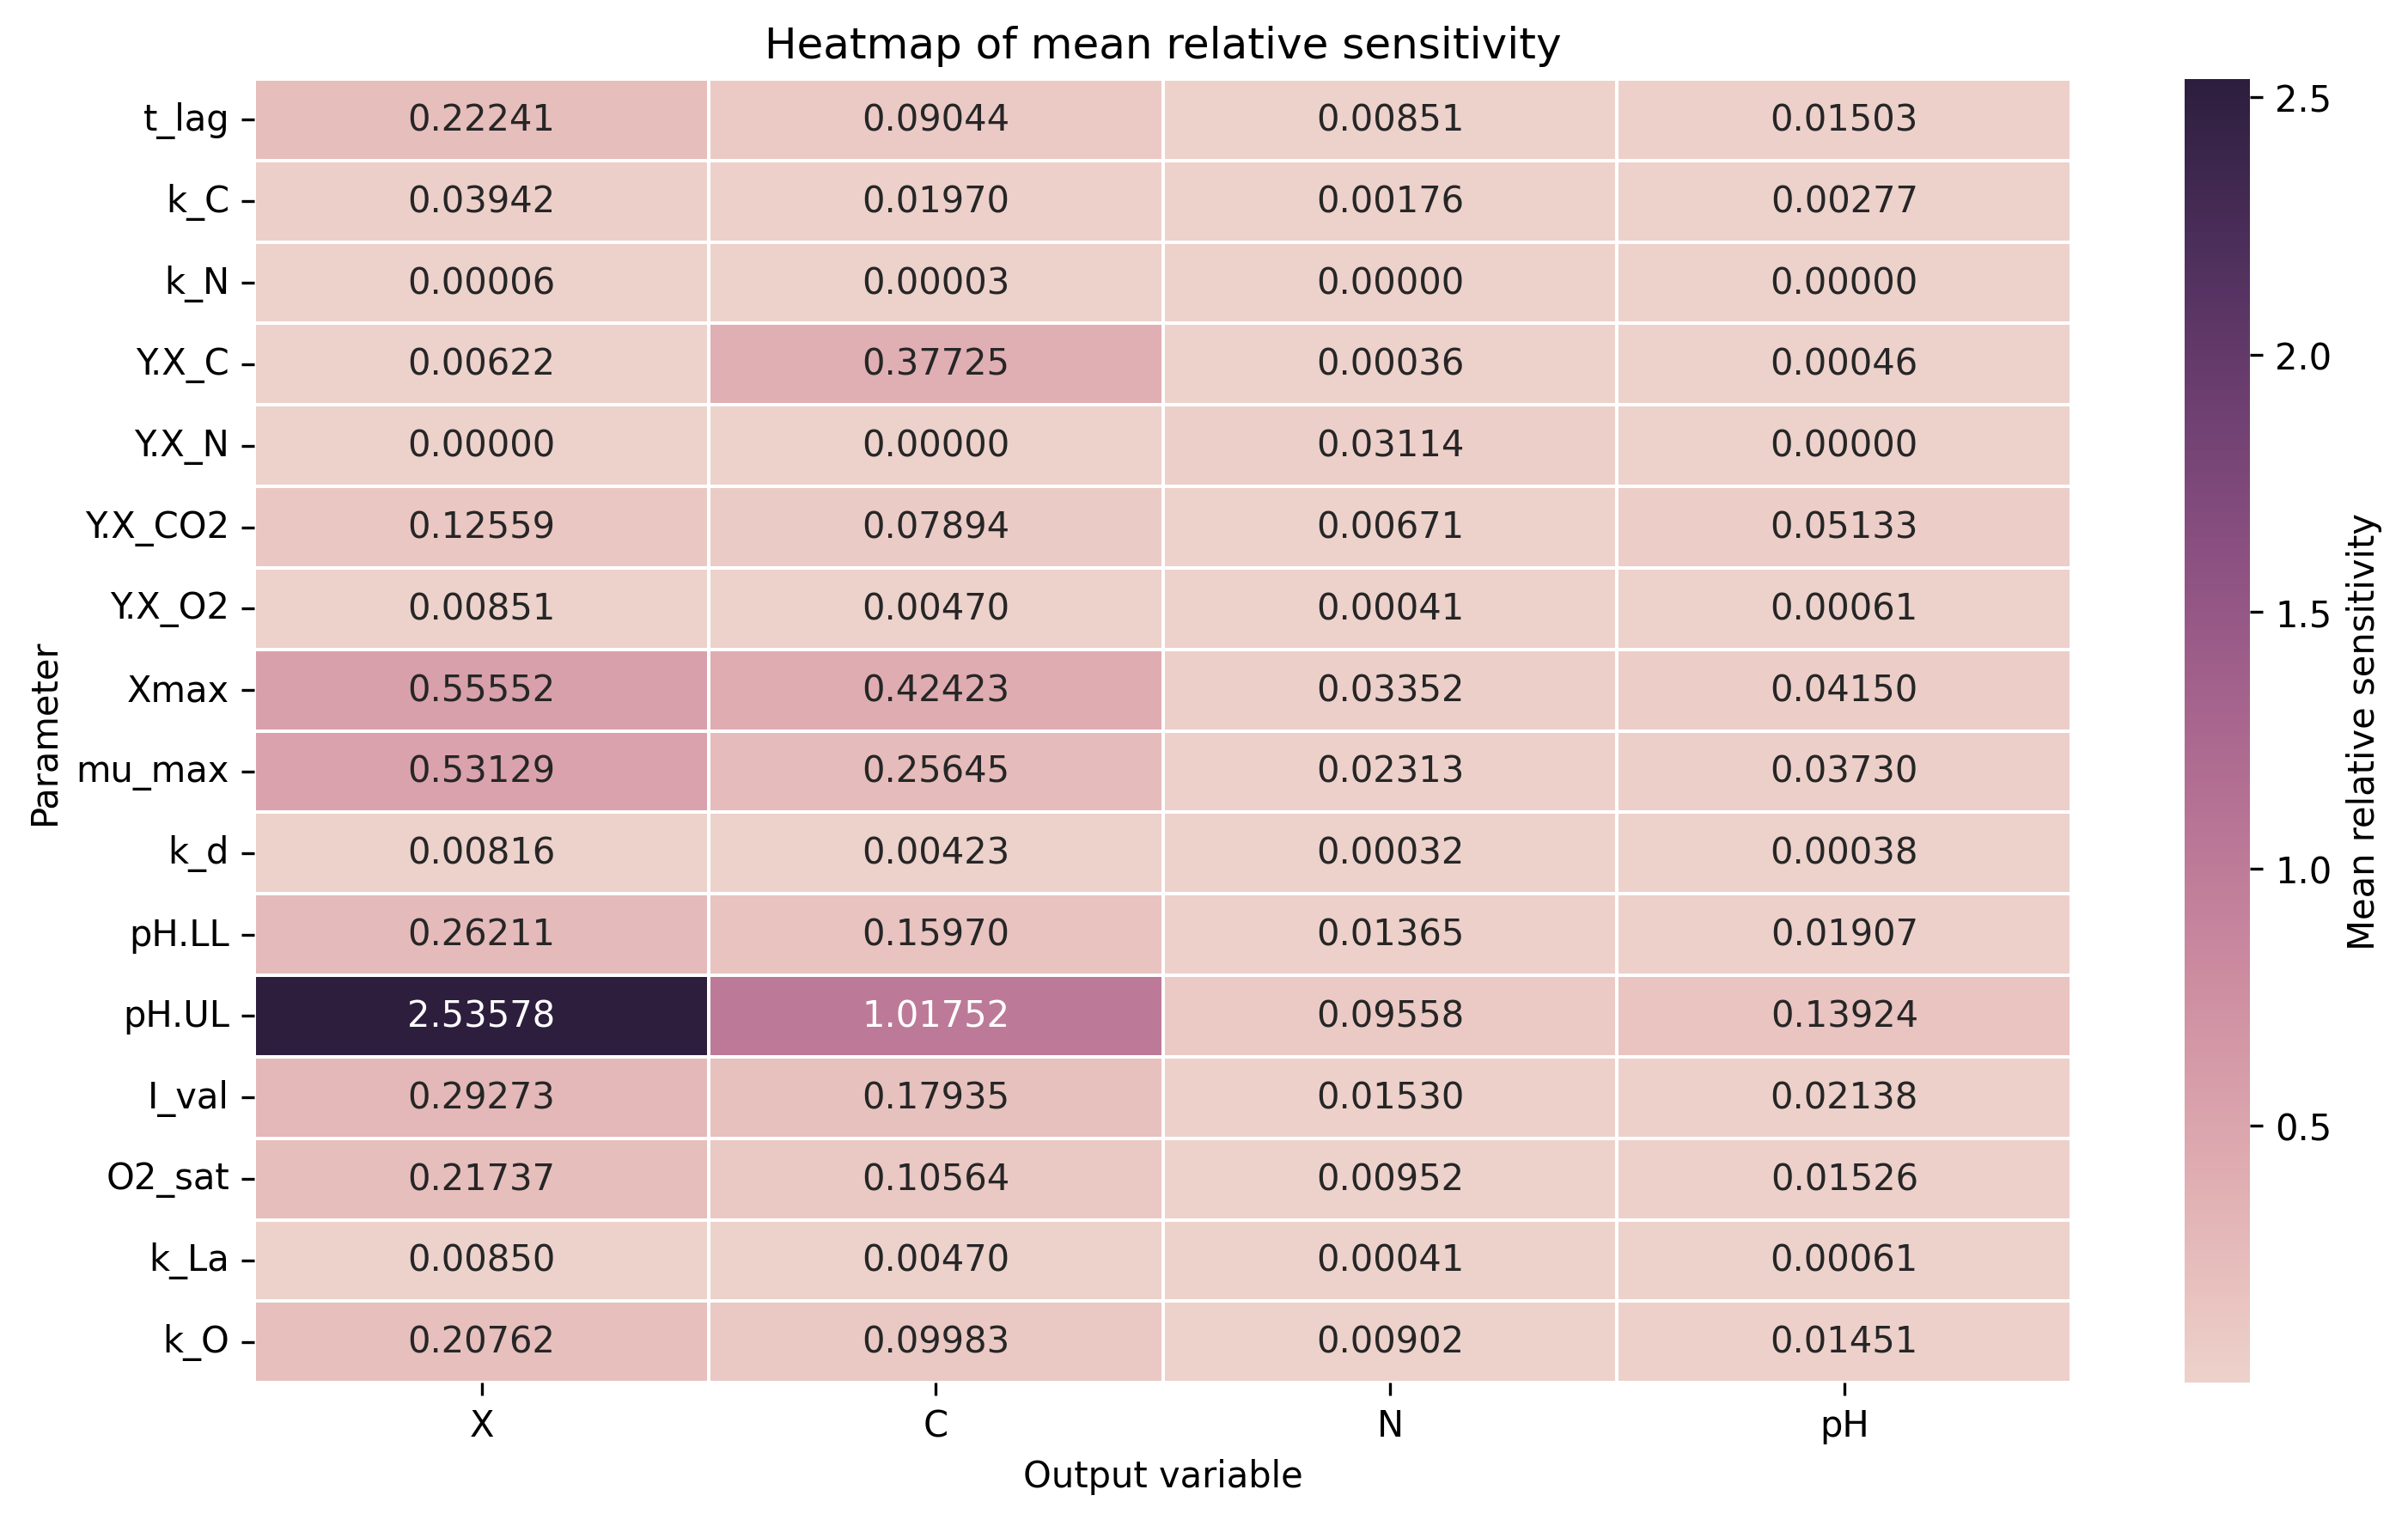

In [26]:
plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(10, max(6, len(sensitivity_df) * 0.3)))
sns.heatmap(
    sensitivity_df,
    cmap=sns.cubehelix_palette(as_cmap=True),
    annot=True,
    fmt=".5f",
    linewidths=0.5,
    cbar_kws={'label': 'Mean relative sensitivity'}
)
plt.title('Heatmap of mean relative sensitivity')
plt.xlabel('Output variable')
plt.ylabel('Parameter')
plt.tight_layout()
plt.show()

#### Barplot

<Figure size 3000x1800 with 0 Axes>

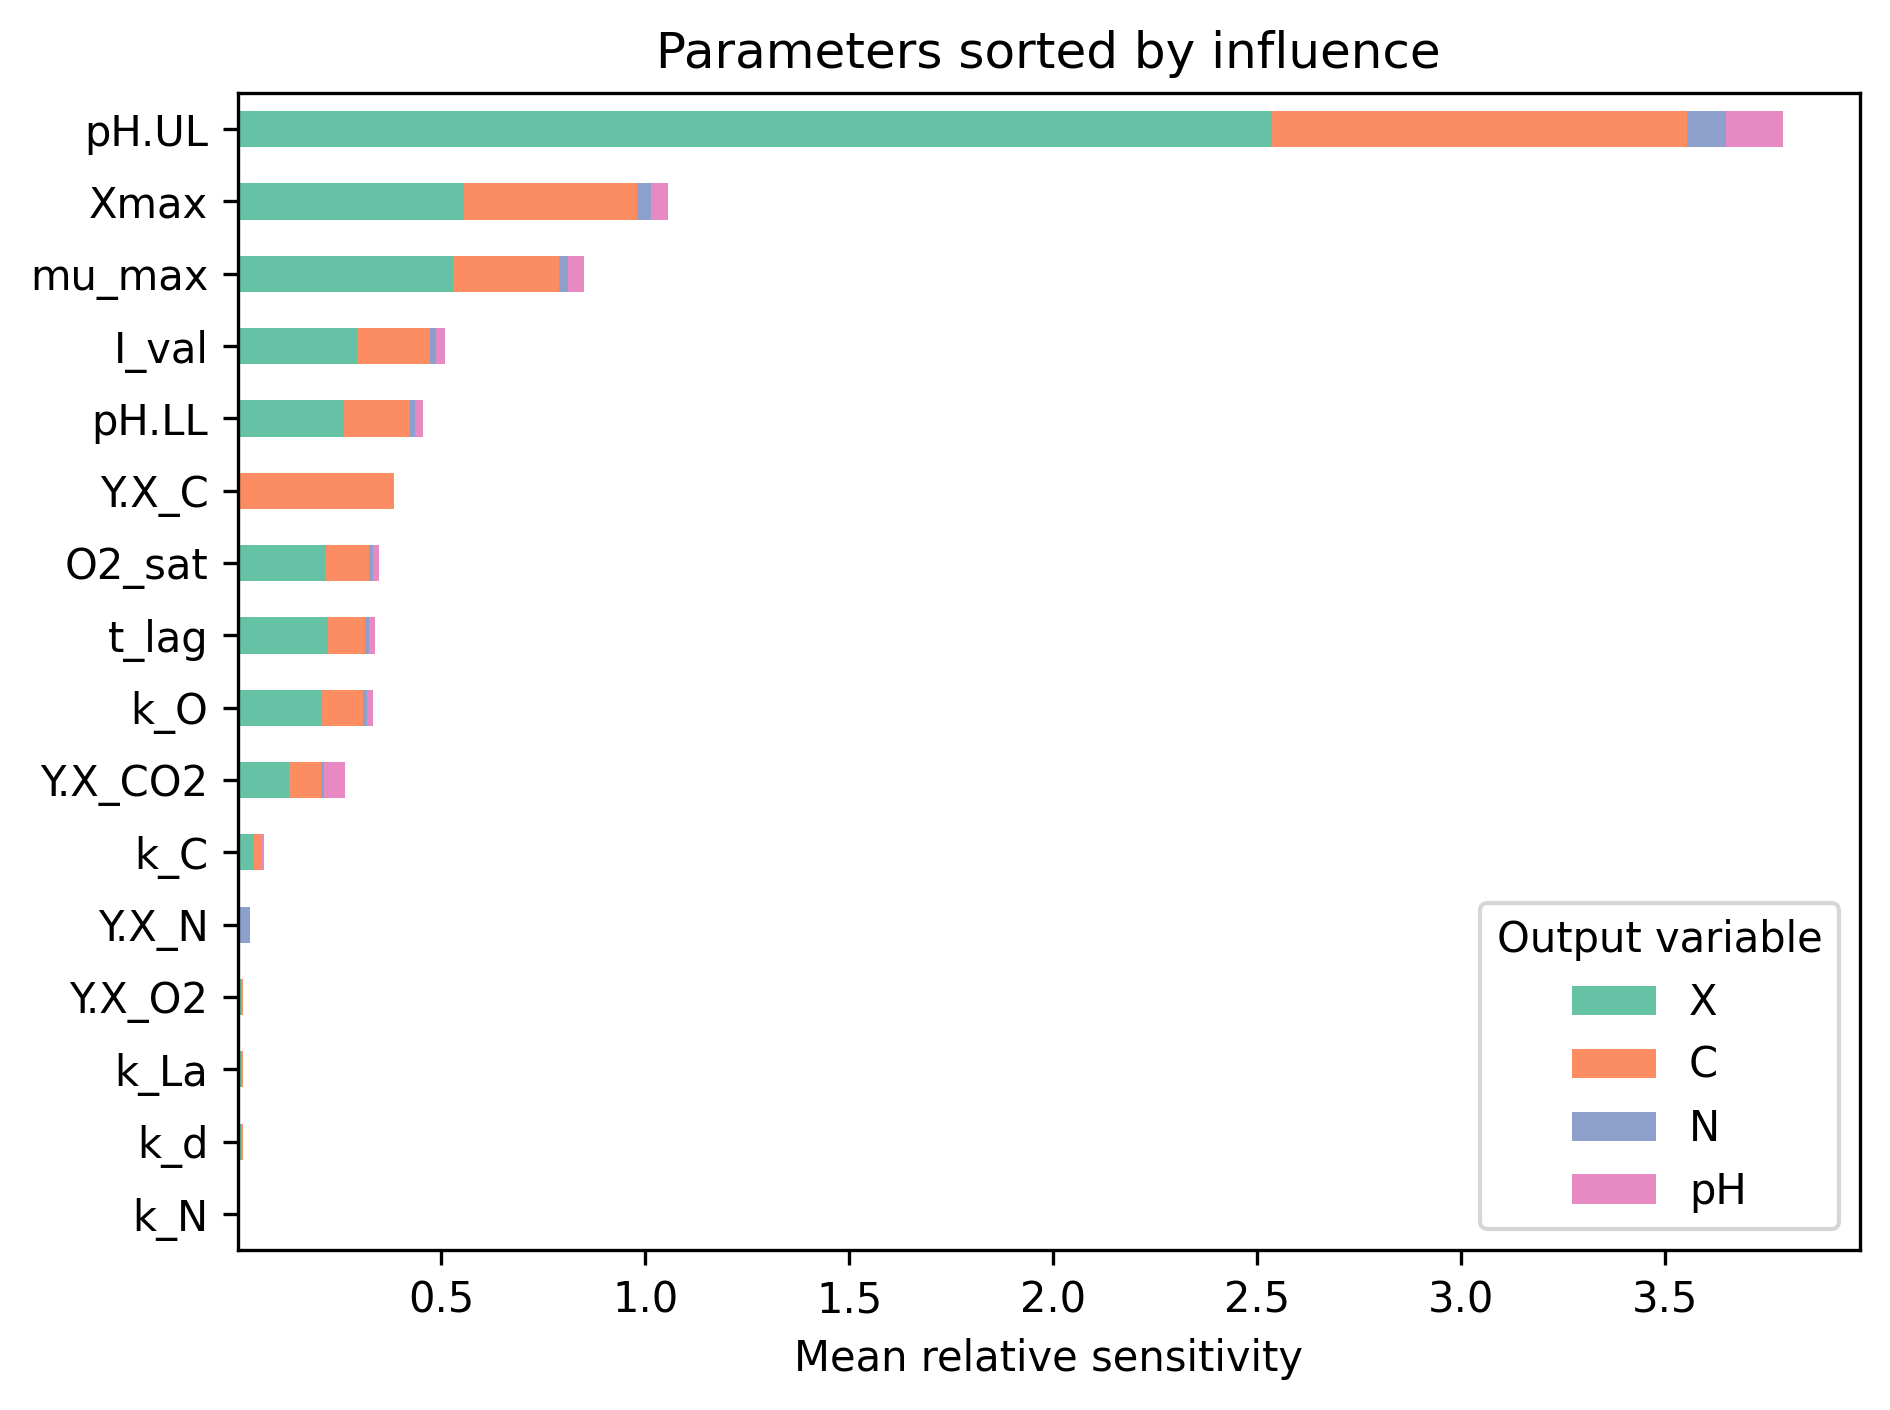

In [27]:
sorted_df = sensitivity_df.sum(axis=1).sort_values(ascending=False)
sorted_keys = sorted_df.index
sorted_plot_df = sensitivity_df.loc[sorted_keys]

palette = sns.color_palette("Set2", n_colors=sensitivity_df.shape[1])

plt.figure(figsize=(10, max(6, len(sorted_plot_df) * 0.3)))
sorted_plot_df.plot(kind='barh', stacked=True, color=palette)

plt.gca().invert_yaxis()
plt.xlabel('Mean relative sensitivity')
plt.title('Parameters sorted by influence')
plt.legend(title='Output variable', loc='lower right', bbox_to_anchor=(1, 0))
plt.tight_layout()
plt.show()

# FIM

In [28]:
param_keys = get_all_numeric_keys(params_o2)

filtered_param_keys = [
    key for key in param_keys
    if not (key.startswith('pH.') and key not in ['pH.LL', 'pH.UL'])
]

print(len(filtered_param_keys))

16


In [29]:
FIM = compute_FIM(filtered_param_keys, params_o2, x_exp, weights_exp)
eigvals = np.linalg.eigvalsh(FIM)
cond_number = np.linalg.cond(FIM)
rank = np.linalg.matrix_rank(FIM)

print(rank)

13


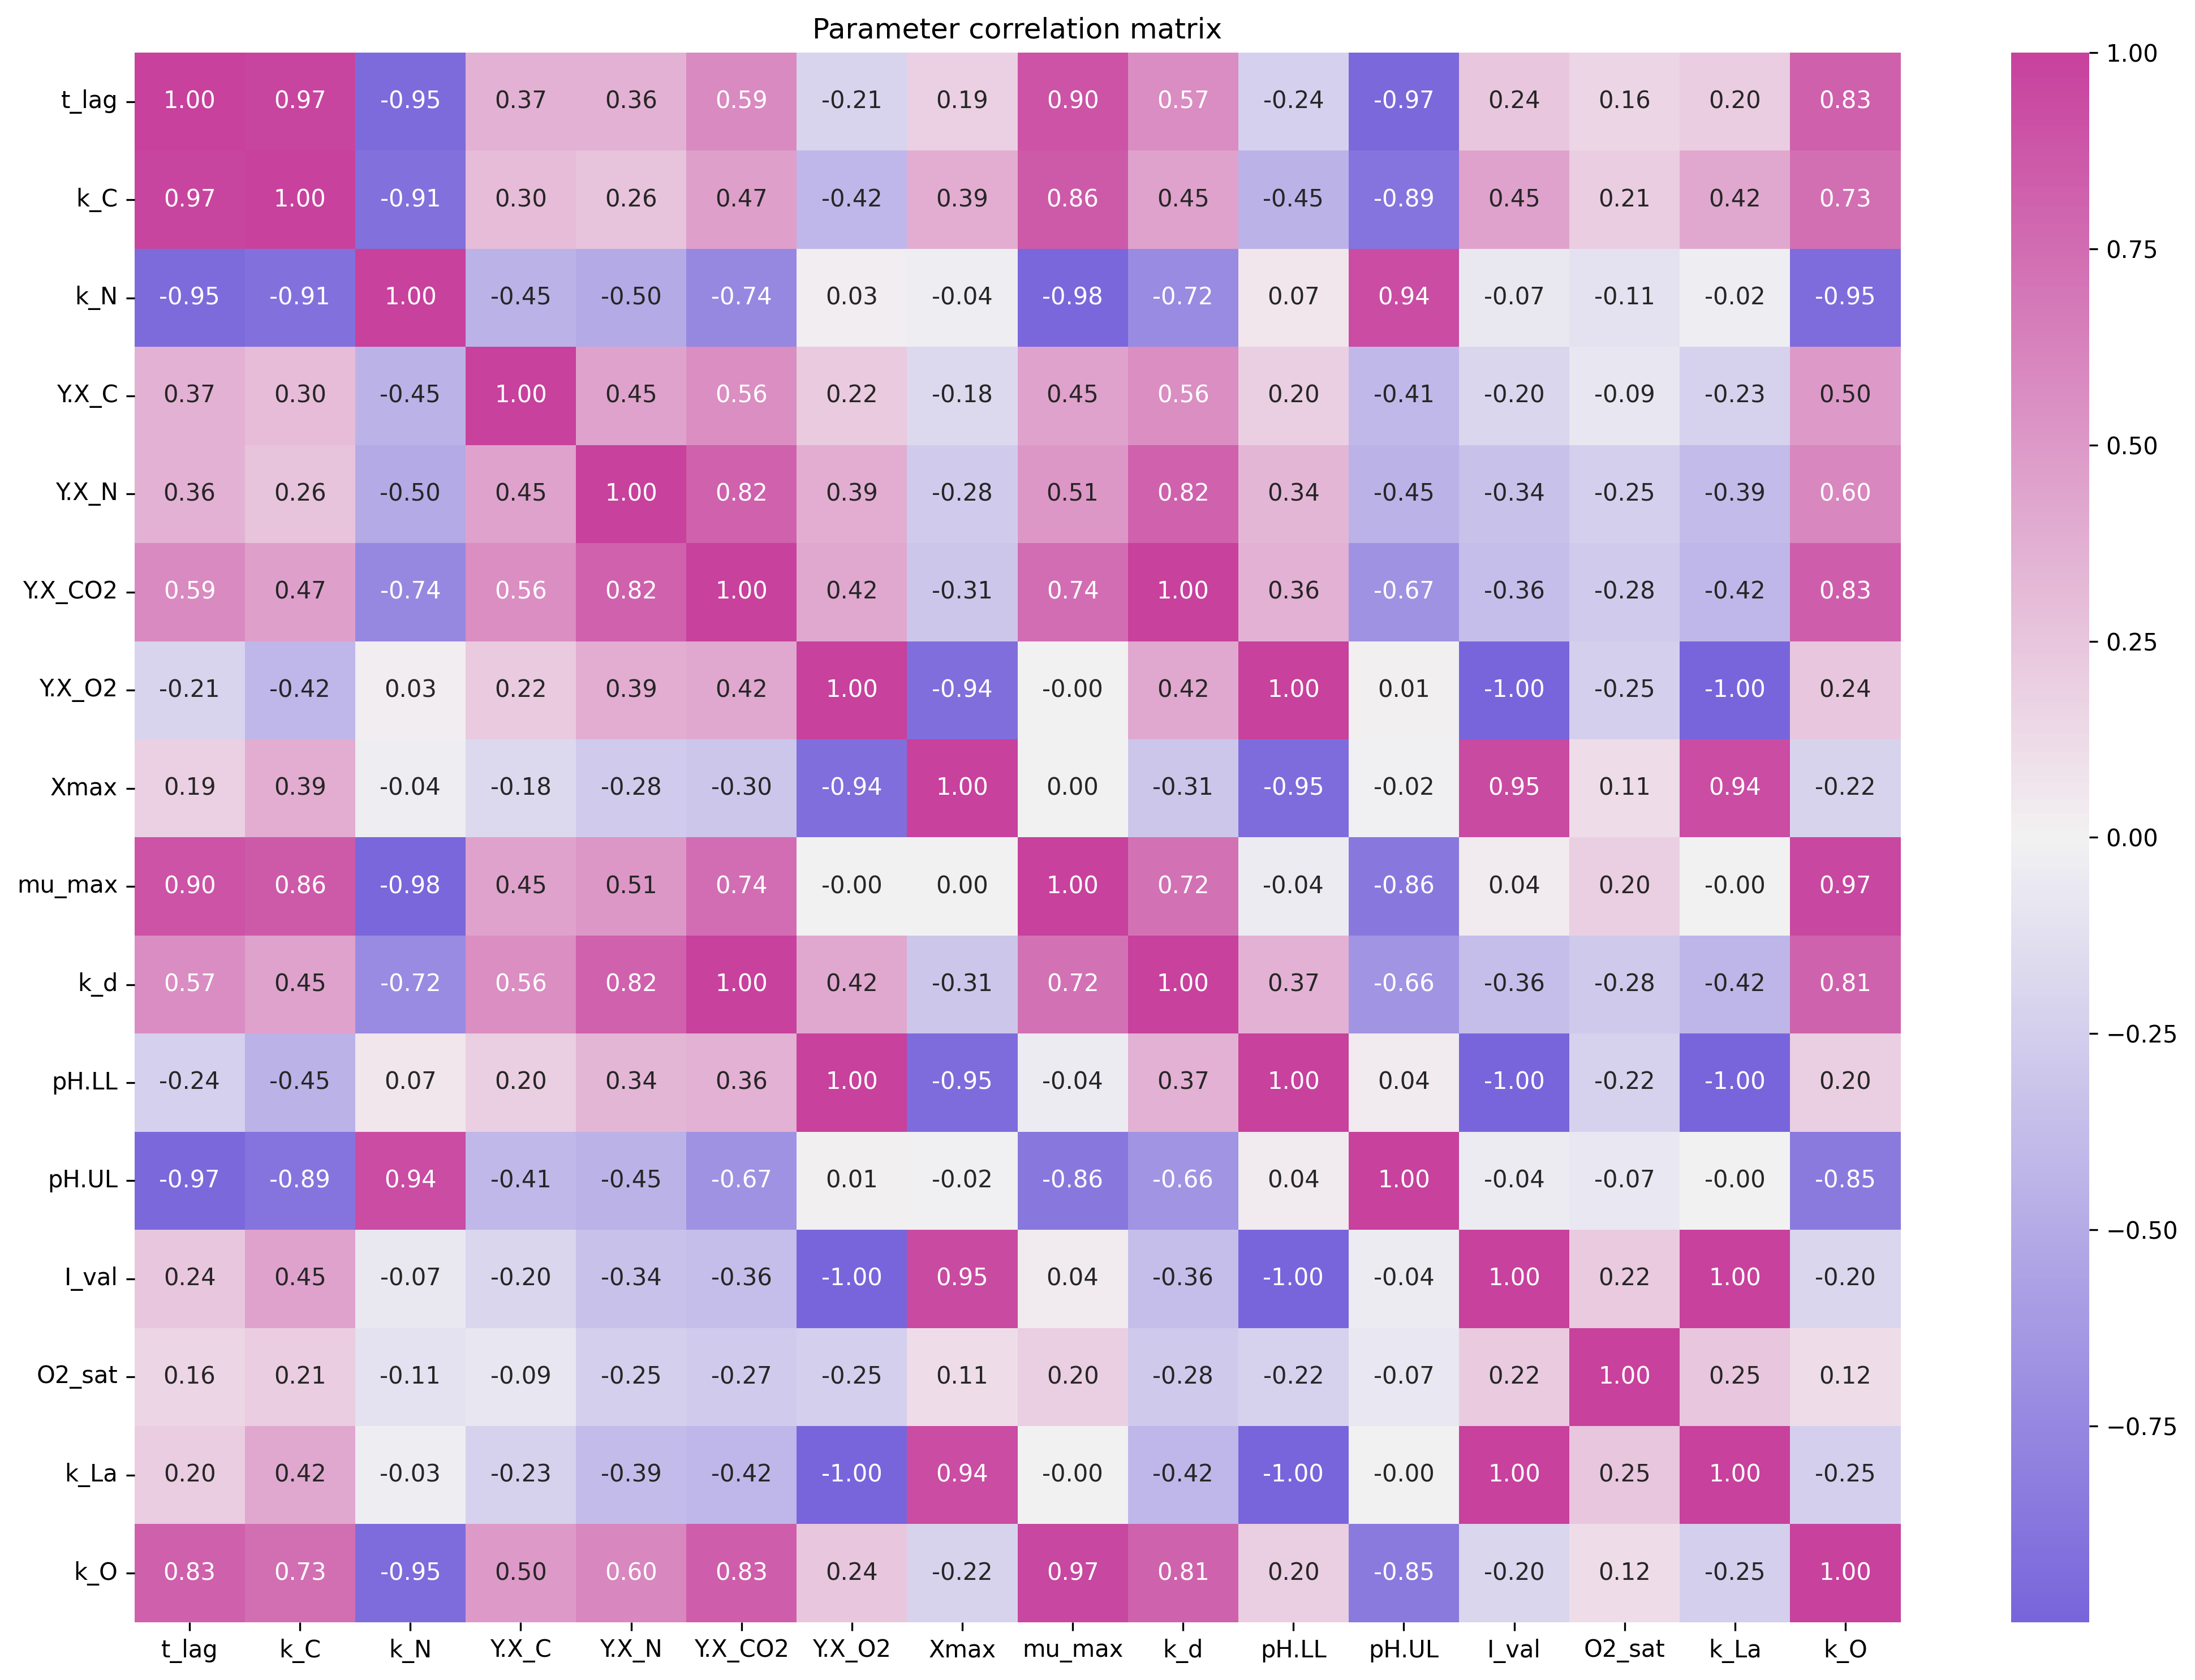

In [30]:
FIM_inv = inv(FIM)
corr_matrix = np.zeros_like(FIM)

for i in range(len(filtered_param_keys)):
    for j in range(len(filtered_param_keys)):
        corr_matrix[i, j] = FIM_inv[i, j] / np.sqrt(FIM_inv[i, i] * FIM_inv[j, j])

plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    xticklabels=filtered_param_keys,
    yticklabels=filtered_param_keys,
    annot=True,
    fmt=".2f",
    cmap=sns.diverging_palette(270, 330, as_cmap=True),
    center=0
)
plt.title("Parameter correlation matrix")
plt.tight_layout()
plt.show()

In [31]:
correlation_threshold = 0.95

highly_correlated_pairs = []

for i in range(len(filtered_param_keys)):
    for j in range(i + 1, len(filtered_param_keys)):
        corr_val = corr_matrix[i, j]
        if abs(corr_val) > correlation_threshold:
            pair = (filtered_param_keys[i], filtered_param_keys[j], corr_val)
            highly_correlated_pairs.append(pair)

for p1, p2, corr in highly_correlated_pairs:
    print(f"{p1:20s} <--> {p2:20s} | corr: {corr:.4f}")

t_lag                <--> k_C                  | corr: 0.9702
t_lag                <--> k_N                  | corr: -0.9543
t_lag                <--> pH.UL                | corr: -0.9704
k_N                  <--> mu_max               | corr: -0.9801
Y.X_CO2              <--> k_d                  | corr: 0.9955
Y.X_O2               <--> pH.LL                | corr: 0.9977
Y.X_O2               <--> I_val                | corr: -0.9976
Y.X_O2               <--> k_La                 | corr: -1.0000
mu_max               <--> k_O                  | corr: 0.9686
pH.LL                <--> I_val                | corr: -1.0000
pH.LL                <--> k_La                 | corr: -0.9975
I_val                <--> k_La                 | corr: 0.9975
